# Double resolution process: River Climatology File

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
single = xr.open_dataset('/home/sallen/MEOPAR/rivers-climatology/rivers_daily_202108.nc')
print (single.nav_lat.shape)
single

(898, 398)


<xarray.Dataset>
Dimensions:       (time_counter: 366, x: 398, y: 898)
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * time_counter  (time_counter) int64 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
Data variables:
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
    area          (y, x) float64 ...
    rorunoff      (time_counter, y, x) float64 ...
    rodepth       (time_counter, y, x) float64 ...
    rotemper      (time_counter, y, x) float64 ...
Attributes:
    acknowledgements:      Based on Morrison et al climatology and Allen and ...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 daily rivers for river_202108
    comment:               daily rivers for river_202108 on coordinates_seagr...
    notebook:              MakeClimatologyRiverFilesWithArea.ipynb
    summary:               Runoff, area, depth and conservative temperature o...
    history:               [2021-08-09] File creation.

In [3]:
double_coordinates = xr.open_dataset('coordinates_SalishSea_double_202206.nc')
nav_lat = double_coordinates.nav_lat[:]
nav_lon = double_coordinates.nav_lon[:]
xsize = double_coordinates.x.shape[0]
ysize = double_coordinates.y.shape[0]

In [14]:
tsize = single.time_counter.shape[0]

In [4]:
def duplicate_copy(single, tsize, ysize, xsize):
    double = np.zeros((tsize, ysize, xsize))
    double[:, 0::2, 0::2] = single[:]
    double[:, 1::2, 0::2] = single[:] 
    double[:, 0::2, 1::2] = single[:]
    double[:, 1::2, 1::2] = single[:] 
    return double

In [11]:
def duplicate_quarter(single, ysize, xsize):
    double = np.zeros((ysize, xsize))
    double[0::2, 0::2] = 0.25 * single[:]
    double[1::2, 0::2] = 0.25 * single[:] 
    double[0::2, 1::2] = 0.25 * single[:]
    double[1::2, 1::2] = 0.25 * single[:] 
    return double

In [12]:
area = duplicate_quarter(single.area[:], ysize, xsize)

In [15]:
rorunoff = duplicate_copy(single.rorunoff, tsize, ysize, xsize)

In [16]:
rodepth = duplicate_copy(single.rodepth, tsize, ysize, xsize)

In [17]:
rotemper = duplicate_copy(single.rotemper, tsize, ysize, xsize)

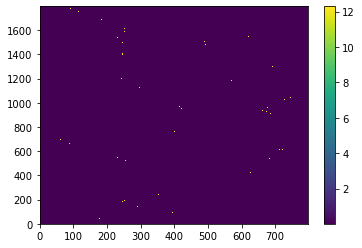

In [34]:
plt.pcolormesh(rotemper[150])
plt.colorbar();

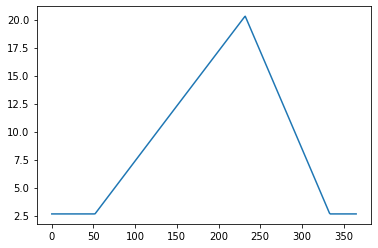

In [32]:
plt.plot(rotemper[:, 1000, 788]);

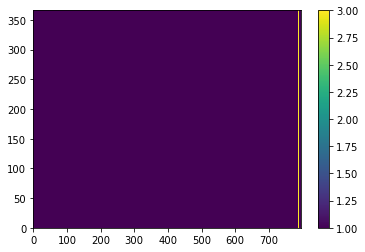

In [21]:
plt.pcolormesh(rodepth[:, 1000, :])
plt.colorbar()

## Write the File ##

In [40]:
filename = 'rivers_daily_double_202206.nc'

In [35]:
# Add some global attributes
ds_attrs = {
    'acknowledgements':
        'from 202108 rivers file',
    'creator_email':
        'sallen@eoas.ubc.ca',
    'creator_name':
        'Salish Sea MEOPAR Project Contributors',
    'creator_url':
        'https://salishsea-meopar-docs.readthedocs.org/',
    'institution':
        'UBC EOAS',
    'institution_fullname': (
        'Earth, Ocean & Atmospheric Sciences,'
        ' University of British Columbia'
    ),
    'summary': (
        'Rivers file, doubled by copying from 202108 file'
    ),
    'source': (
        'tools/double_resolution/river_T_D.ipynb'
    ),
    'history': (
        '[{}] File creation.'
        .format(datetime.datetime.today().strftime('%Y-%m-%d'))
    )
}

In [37]:
da = {}
interpl = {
    'nav_lat': nav_lat,
    'nav_lon': nav_lon,
    'area': area,
    'rorunoff': rorunoff,
    'rotemper': rotemper,
    'rodepth': rodepth,
}
for var in interpl.keys():
    if var == 'nav_lat' or var == 'nav_lon' or var == 'area':
        dims = ('y', 'x')
        coords = {'y': np.arange(ysize), 'x': np.arange(xsize)}
    else:
        dims = ('time_counter', 'y', 'x')
        coords = {'time_counter': single.time_counter[:], 'y': np.arange(ysize), 'x': np.arange(xsize)}            
    da[var] = xr.DataArray(
        data=interpl[var],
        name=var,
        dims=dims,
        coords=coords,
    )

In [38]:
ds = xr.Dataset(
    data_vars=da,
    coords=coords,
    attrs=ds_attrs
)

In [41]:
encoding = {var: {'zlib': True} for var in ds.data_vars}
ds.to_netcdf(
    path=filename,
    unlimited_dims=('time_counter'),
    encoding=encoding,
)

In [28]:
double_coordinates.close()